In [1]:
# Import necessary libraries
import pandas as pd
import plotly.graph_objects as go
import dalmatian
from google.cloud import storage
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np

from plotly.subplots import make_subplots
import model_helper 
from helper import *
from plotly_helper import *

In [2]:
# Input patient information
patient_id = 'GCLL-0157'
wbc_file = 'CLL8 CLL cell count 05222025 UPDATED.csv'
treatment_file = 'GCLL_treatment.txt'
UMI_start = 1
UMI_end = 5 
# 
treatment_start = 0


In [3]:
clusters=[1, 2, 3, 4,5]

In [4]:
# Manually verify the sample list order is correct

In [5]:
sample_list = ['GCLL-0157-T-01',
       'RP-1895_PDO-34670_SM-NPXSQ_GCLL-0157-MRD-01_v1_Custom_Selection_OnPrem','RP-1895_PDO-33508_SM-NKJZW_GCLL-0157-MRD-02_v1_Custom_Selection_OnPrem','RP-1895_PDO-34670_SM-NPXSB_GCLL-0157-MRD-03_v1_Custom_Selection_OnPrem','RP-1895_PDO-33508_SM-NKK15_GCLL-0157-MRD-04_v1_Custom_Selection_OnPrem', 'GCLL-0157-T-02']

In [6]:
# Output file

In [7]:
outputfile_name = "CLL_subplot_combined_0157_wbc_updated.html"

In [8]:


# Function to load data
def load_data(patient_id, wbc_file, treatment_file):
    # Load WBC and treatment data
    wbc_df = pd.read_csv(wbc_file)
    treatment_df = pd.read_csv(treatment_file, sep='\t')
    
    # Get input files from Terra through dalmatian
    workspace = 'broad-firecloud-ibmwatson/TAG_CLL_Clonal_Kinetic_UMI_PrAN'
    wm = dalmatian.WorkspaceManager(workspace)
    participants = wm.get_participants()
    
    # Load additional data for the patient
    cluster_CCF_df = pd.read_csv(participants.loc[patient_id]['cluster_ccfs'], sep='\t')
    abundance_df = pd.read_csv(participants.loc[patient_id]['abundances_tsv'], sep='\t')
    mcmc_df = pd.read_csv(participants.loc[patient_id]['cell_population_mcmc_trace'], sep='\t')
    tree_df = pd.read_csv(participants.loc[patient_id]['tree_tsv'], sep='\t')
    
    return wbc_df, treatment_df, cluster_CCF_df, abundance_df, mcmc_df, tree_df

# Function to filter data for a specific patient
def filter_patient_data(wbc_df, patient_id):
    wbc_df_patient = wbc_df[wbc_df['Patient'] == patient_id]
    wbc_df_patient.reset_index(drop=True, inplace=True)
    sample_list = wbc_df_patient['Timepoint'].dropna().tolist()
    times_sample = [int(i) for i in wbc_df_patient.loc[wbc_df_patient.Sample.notna(), 'Time_since_start_tx'].tolist()]
    wbc_all = [float(i) for i in wbc_df_patient['WBC'].tolist()]
    
    
    CLL_count_sample = [float(i) for i in wbc_df_patient.loc[wbc_df_patient.Sample.notna(), 'CLL count estm'].tolist()]
    all_times = [int(i) for i in wbc_df_patient['Time_since_start_tx'].to_list()]
    
    return wbc_df_patient, times_sample, CLL_count_sample, wbc_all,all_times





Update patient specific information in the below cell 

In [9]:
end_treatment_df = pd.read_csv("CLL8_end_treatment.csv")

In [10]:
# Get the treatment duration 

treatment_end = end_treatment_df[end_treatment_df.Patient == patient_id].Treatment_duration.iloc[0]

In [11]:
treatment_end

53

In [12]:

wbc_df, treatment_df, cluster_CCF_df, abundance_df, mcmc_df, tree_df = load_data(patient_id, wbc_file, treatment_file)

# Filter data for the specific patient
wbc_df_patient, times_sample, CLL_count_sample,wbc_count, all_times = filter_patient_data(wbc_df, patient_id)

# Plot CLL count over time and save as HTML
CLL_plot_html = plot_CLL_count(patient_id, times_sample, CLL_count_sample, UMI_start, UMI_end, treatment_start, treatment_end, )
    




In [13]:
wbc_count_log = [np.log(x) for x in wbc_count]

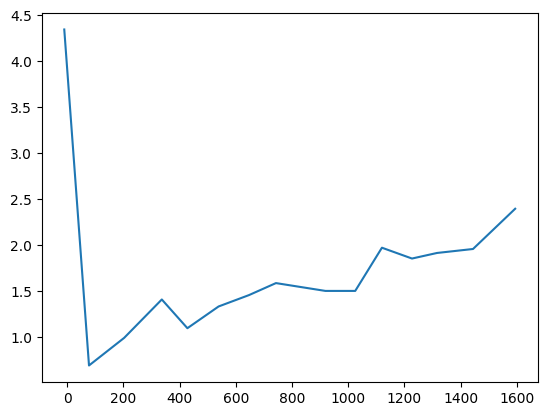

In [14]:
plt.plot(all_times,wbc_count_log)

In [15]:
CLL_count_sample

[47.926, 0.12128463, 0.49841233, 0.86442036, 1.30980632, 7.26]

In [16]:
wbc_table_html = plot_metadata_table(wbc_df_patient, patient_id )

In [17]:
 plot_tree_html = plot_tree_plotly(tree_df, 0)

In [17]:
 plot_ccf_html = plot_ccf(cluster_CCF_df, times_sample, treatment_df,)

In [44]:
branch_annotations = {
    
    2: "RPS15_None", 
    3: "KRAS_None, SF3B1_None, TP53_None"
}

In [19]:
ccf_tree_html = plot_ccf_tree_combined(
    tree_df=tree_df,
    tree_selected=0,
    ccf_df=cluster_CCF_df,
    times_sample=times_sample,
    treatment_df=treatment_df,
    branch_annotations=branch_annotations

)

In [20]:
CLL_count_sample

[47.926, 0.12128463, 0.49841233, 0.86442036, 1.30980632, 7.26]

In [21]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)
subclone_sample, log_subclone_sample = model_helper.calc_subclone(CLL_count_sample, cluster_abundance, cluster_list)
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [22]:
#  Add noise to all abundance

import random 
random.seed(42)
def add_uniform_noise_and_normalize(lst, low=0, high=0.01):
    
    # Add uniform noise
    noisy_lst = [x + random.uniform(low, high) for x in lst]

    
    # Normalize the list
    total_sum = sum(noisy_lst)
    
    normalized_lst = [x / total_sum for x in noisy_lst]

    return normalized_lst


subclone_cluster_iter = {}
# Iterate through each cluster
for cluster, iterations in all_abundance.items():
   
    # Iterate through each iteration in the cluster
    for iteration, value in iterations.items():
        # If the iteration is not in the new dict, add it
        if iteration not in subclone_cluster_iter:
            subclone_cluster_iter[iteration] = {}
        # Add the cluster and its value to this iteration
        subclone_cluster_iter[iteration][cluster] = value

        
        
noise_added_iter = {}

for iteration, abundances in subclone_cluster_iter.items():
    
    transposed_data = {i: list(values) for i, values in enumerate(zip(*abundances.values()), start=1)}
    
    noise_added_iter[iteration] = {}
    for time_point, abundance in transposed_data.items():
        
#         print(time_point, abundance)
        noise_abundance = add_uniform_noise_and_normalize(abundance)
    
#         print(noise_abundance)

        noise_added_iter[iteration][time_point] = add_uniform_noise_and_normalize(abundance)

    
noise_added_all_abundance = {}
for iteration, abundances in noise_added_iter.items():
    original_format = {i + 1: list(values) for i, values in enumerate(zip(*abundances.values()))}
    noise_added_all_abundance[iteration] = original_format
    
    
noise_added_original_all_abundances = {}

for iteration, abundances in noise_added_all_abundance.items():
    
    for cluster, abundance_value in abundances.items():
        if cluster not in noise_added_original_all_abundances:
            noise_added_original_all_abundances[cluster] = {}
        noise_added_original_all_abundances[cluster][iteration] = abundance_value
            

In [23]:
subclone_sample_mcmc_with_uniform_noise, log_subclone_sample_mcmc_with_uniform_noise = model_helper.calc_subclone(CLL_count_sample, noise_added_original_all_abundances, cluster_list, input_type = "mcmc")

In [24]:
times_aft_tx = [x for x in all_times if x > treatment_end]
times_aft_tx.insert(0, treatment_end)

# Set the extrapolate time after treatment
extrapolate_start_idx = 1

In [25]:
times_sample

[-10, 1025, 1120, 1227, 1316, 1594]

In [26]:
times_aft_tx

[53, 78, 203, 337, 428, 539, 647, 743, 919, 1025, 1120, 1227, 1316, 1444, 1594]

In [27]:
# Generate Plotly plot
subclone_plot_html = plot_subclones(cluster_list, times_sample, CLL_count_sample, log_subclone_sample, extrapolate_start_idx, times_aft_tx, treatment_df, treatment_end)


In [28]:
linear_model_mcmc_html = plot_linear_model_mcmc(cluster_list,times_sample,  CLL_count_sample, log_subclone_sample_mcmc_with_uniform_noise,extrapolate_start_idx,times_aft_tx,treatment_df, treatment_end)  

In [29]:
# Convert the column "CLL count estm" to float 
wbc_df_patient['CLL count estm'] = wbc_df_patient['CLL count estm'].astype(float) 
times_sliced_aft = [int(i) for i in wbc_df_patient[wbc_df_patient['CLL count estm'] > 0]['Time_since_start_tx'].values  if int(i) > 0]

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_9926/981427378.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
times_aft_tx

[53, 78, 203, 337, 428, 539, 647, 743, 919, 1025, 1120, 1227, 1316, 1444, 1594]

In [31]:
# Needs to manually check times_sliced_aft

In [32]:
times_sliced_aft

[78, 647, 743, 919, 1025, 1120, 1227, 1316, 1444, 1594]

In [33]:
len(times_sliced_aft)

10

In [34]:
index_samples_model = slice(1,6)

# index_samples_model is the index of the samples after treatment. For instance, slice(1,7) means sample 2, 3, 4, 5,6, 7

X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,2, index_samples_model, times_sample)



In [35]:
wbc_aft_tx = wbc_df_patient[wbc_df_patient.Time_since_start_tx > treatment_end]['CLL count estm'].to_list()
wbc_model = [i for i in wbc_aft_tx if i > 0]

In [36]:
wbc_model

[0.00120455,
 0.00114246,
 0.00467897,
 0.05080938,
 0.12128463,
 0.49841233,
 0.86442036,
 1.30980632,
 1.83054935,
 7.26]

In [37]:
len(wbc_model)

10

In [38]:
n_clusters = len(cluster_list)
logsumexp_points = np.log(wbc_model)
model = MultiClusterLinearRegression(n_clusters, X, y)
model.fit(logsumexp_points)

In [39]:
x_year_selected = [i / 365 for i in np.array(times_sliced_aft)]

In [40]:
CLL_count_sample

[47.926, 0.12128463, 0.49841233, 0.86442036, 1.30980632, 7.26]

In [41]:
# Generate Plotly plot
subclone_plot_new_model_html = plot_subclones_new_model(cluster_list, times_sample, wbc_model, log_subclone_sample, extrapolate_start_idx, times_aft_tx, times_sliced_aft, treatment_df,treatment_end, model )


In [42]:
plot_mcmc_new_model_html = plot_mcmc_model(clusters, index_samples_model, times_aft_tx, times_sample, times_sliced_aft, sample_list, wbc_model, log_subclone_sample_mcmc_with_uniform_noise, treatment_df, treatment_end)


In [43]:
create_html_file([wbc_table_html, plot_ccf_html, ccf_tree_html, CLL_plot_html, subclone_plot_html,linear_model_mcmc_html,subclone_plot_new_model_html, plot_mcmc_new_model_html], output_file=outputfile_name)

HTML file saved as CLL_subplot_combined_0157_wbc_updated.html
